__Author__: Vladimir Koltunov

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction/Business Problem <a name="introduction"></a>

London is one of the largest and busiest city in Europe. It also one of the world's capitals of finance, culture, art and entertainment. With all of its cultural diversity it provides many opportunities for new businessess and working professionals. Greater London Authority published population projection for the city and updated it annually at both local authority and ward level for year up to 2050.

In the modern worlds of cosmopolites and fast changing trends it becomes increasingly important to examine and understand all these changes quantitatively. City government and urban planners, enterpreneurs and investors - all have an interest in identifying early opportunities and growing urban footprint in prospective districts.

My idea here is that using population projection data and current venues information (from extensive Foursquare database) I can do following analysis:
 - classify neighbourhoods to following categories: underdeveloped, business center or downtown, highly developed;
 - explore underdeveloped neighbourhoods looking at significant population growth;
 - identify opportunities for new businesses in urbanizing heighbourhoods;

## Data <a name="data"></a>

For this analysis I will use following sources of data:

- Statistical GIS Boundary Files for London, published on [London Datastore](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london). It contains National Statistics data © Crown copyright and database right [2015]" and "Contains Ordnance Survey data © Crown copyright and database right [2015]".
- Greater London Authority Population and Household Projections dataset, published on [London Datastore](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough). From this source we can take following data: ward name, ward location, ward current population and population projection for years 2020-2050.
- London Ward Profiles and Atlas by [London Datastore](https://data.london.gov.uk/dataset/ward-profiles-and-atlas). We will take all the additional information about wards from here: borough it belongs to, what part of city it belongs to, etc
- Venues data using [Foursquare API](http://developer.foursquare.com). From this source we can take following data: list of venues names and locations in each ward of interest, also venue category (we will only need high level category, which will extract also from Foursquare, but as list of categories, available [here](https://developer.foursquare.com/docs/resources/categories)).

#### Download geospatial boundary files for London

First of all let's download boundaries of wards published by Greater London Authority, published on London Datastore.

It contains National Statistics data © Crown copyright and database right [2015]" and "Contains Ordnance Survey data © Crown copyright and database right [2015]"

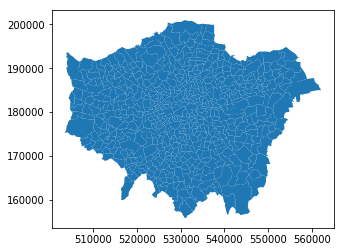

In [119]:
wards.plot()

#### Calculate centroids coordinates for each ward

For analysis we will need centroids location for every ward. We will save this coordinates to the GeoDataFrame itself.

In [123]:
wards['centroid_lat'] = wards.geometry.centroid.y # centroid latitude
wards['centroid_lon'] = wards.geometry.centroid.x # centroid longitude

wards.head()

NAME   GSS_CODE              DISTRICT  LAGSSCODE  \
0       Chessington South  E05000405  Kingston upon Thames  E09000021   
1  Tolworth and Hook Rise  E05000414  Kingston upon Thames  E09000021   
2              Berrylands  E05000401  Kingston upon Thames  E09000021   
3               Alexandra  E05000400  Kingston upon Thames  E09000021   
4                Beverley  E05000402  Kingston upon Thames  E09000021   

   HECTARES                                           geometry  centroid_lat  \
0   755.173  POLYGON ((-0.33068 51.32901, -0.33059 51.32909...     51.347966   
1   259.464  POLYGON ((-0.28409 51.36515, -0.28473 51.36541...     51.374269   
2   145.390  POLYGON ((-0.30385 51.39249, -0.30375 51.39252...     51.392646   
3   268.506  POLYGON ((-0.27257 51.37227, -0.27263 51.37228...     51.383887   
4   187.821  POLYGON ((-0.25873 51.40956, -0.25869 51.40955...     51.402740   

   centroid_lon  
0     -0.312027  
1     -0.289905  
2     -0.289457  
3     -0.275273  
4     -0.258938

#### Filtering wards

In our analysis we will focus only on central parts of Greater London. It's called Inner London. Which districts belongs Inner London we'll take from [London Borough Profiles dataset](https://data.london.gov.uk/dataset/london-borough-profiles)

In [153]:
inner_wards.shape

(251, 8)

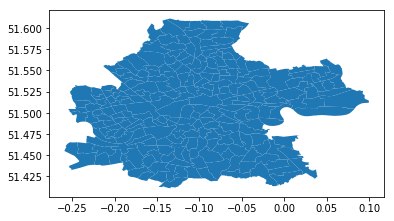

In [129]:
inner_wards.plot()

## Retrieve Venues information using Foursquare API

#### Estimate radius for Foursquare search

In [187]:
radiuses = np.sqrt(inner_wards.HECTARES * 10000 / math.pi) # calculate radius of the ward if it has circular shape
print("Radius spread is [{}, {}] with mean={} and median={}".format(radiuses.min(), radiuses.max(), radiuses.mean(), radiuses.median()))
radiuses[:5]

Radius spread is [350.77894692128564, 1410.6860782026301] with mean=623.4783740975953 and median=592.1061490490441


0    735.199860
1    678.842229
2    679.322682
3    684.429636
4    585.668464
Name: HECTARES, dtype: float64

Radius of __750 meters__ will be more than enough for search

#### Get venues for every ward

In [252]:
import time
import random
def fill_venues():
    for i, row in inner_wards_venues.iterrows():
        for category in categories_list:
            if row[category[0]] is None:
                try:
                    inner_wards_venues.loc[i, category[0]] = venues_count(row.centroid_lat, row.centroid_lon, category[1])
                    time.sleep(0.2 + .2 * random.random())
                except ValueError as err:
                    print('Exception at %i row for category=%s. Error: %s' % (i, category, err))
                    return
fill_venues()
inner_wards_venues.head()

NAME  WARD_CODE  centroid_lat  centroid_lon  \
0  Streatham South  E05000431     51.417380     -0.130382   
1    St. Leonard's  E05000428     51.429830     -0.133502   
2  Streatham Wells  E05000432     51.429980     -0.121877   
3    Knight's Hill  E05000424     51.429287     -0.107899   
4         Thornton  E05000433     51.447030     -0.136736   

   Arts & Entertainment  College & University  Event  Food  Nightlife Spot  \
0                     0                     1      0     7               6   
1                     6                     0      0    27               8   
2                     6                     3      0    22               7   
3                     3                     0      0    14               6   
4                     0                     3      0     4               3   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0                      5                            6          1   
1                      5                           12          2   
2                      4                           15          2   
3                      4                           10          1   
4                      3                            5          5   

   Shop & Service  Travel & Transport  
0              10                   3  
1              33                   5  
2              29                   4  
3              21                   4  
4               7                   6

# Methodology <a name="methodology"></a>

In this project we will try to find clusters of similar areas across Inner London based on frequencies of different categories of venues which are presented in these areas.


First step was to collect needed data which is list of London areas(wards), their boundaries and central points. Also we gathered venue information in these areas using public Foursquare API.


Next step will be the exploratory analysis and clustering itself. We will normalize number of venues in different areas. And after that we will apply K-means clustering algorithm to find similar groups of wards in London based on their venue "background". We will try to find clusters with different level of development. This can help us identify highly developed and under developed (or oportunistic) areas in the city.

In final step we will take a look at population projection for different areas and clusters. The main goal here is to understand whether or not urban footprint will grow.

# Analysis <a name="analysis"></a>

## Exploratory Data Analysis of Wards

First of all, we will normalize all the data to scale from 0 to 1.

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaled_wards = MinMaxScaler().fit_transform(inner_wards_venues.values[:, 4:])

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
wards_venues_scaled = pd.DataFrame(scaled_wards, columns=inner_wards_venues.columns[4:].values)
wards_venues_scaled.head()

Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.000000              0.008850  0.024291        0.042254   
1              0.065934              0.000000  0.105263        0.056338   
2              0.065934              0.026549  0.085020        0.049296   
3              0.032967              0.000000  0.052632        0.042254   
4              0.000000              0.026549  0.012146        0.021127   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0                   0.04                     0.028169    0.03125   
1                   0.04                     0.070423    0.06250   
2                   0.03                     0.091549    0.06250   
3                   0.03                     0.056338    0.03125   
4                   0.02                     0.021127    0.15625   

   Shop & Service  Travel & Transport  
0        0.046729             0.01875  
1        0.154206             0.03125  
2        0.135514             0.02500  
3        0.098131             0.02500  
4        0.032710             0.03750

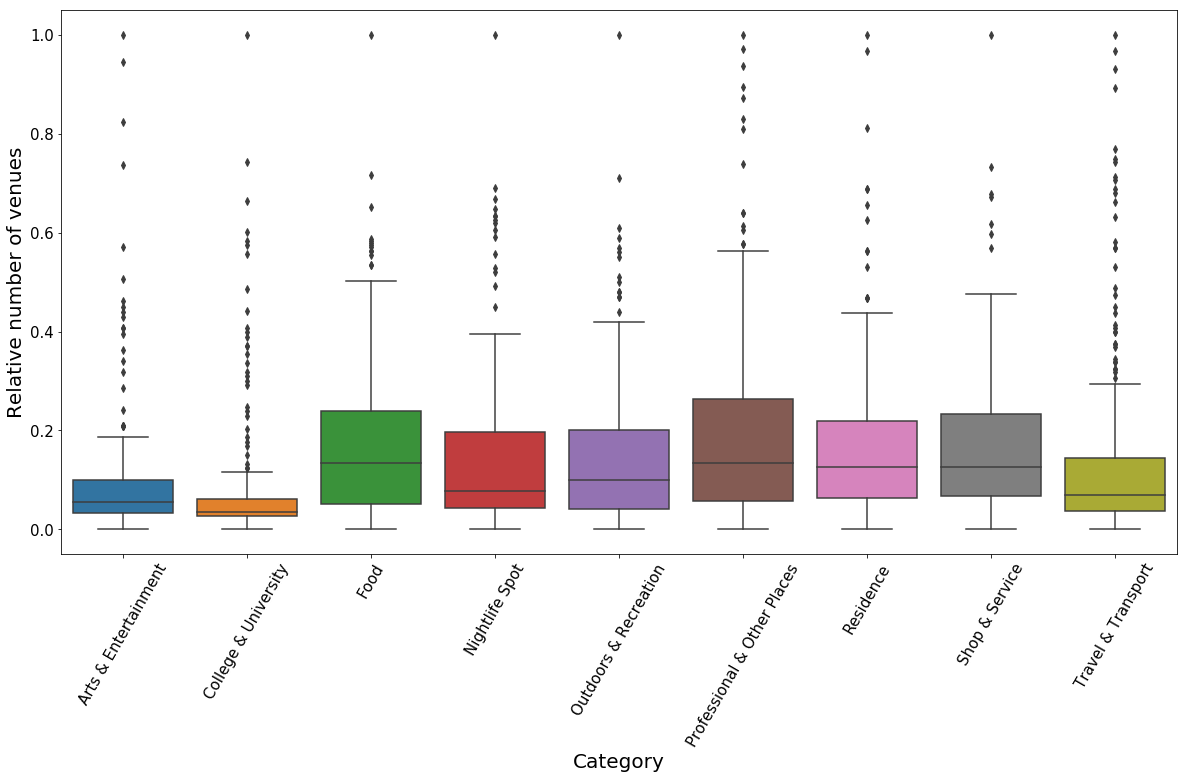

In [299]:
plt.figure(figsize=(20, 10))
sns.boxplot(data = wards_venues_scaled)
plt.tick_params(labelsize=15)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Relative number of venues', fontsize=20)
plt.xticks(rotation=60)

plt.show()

# Clustering

For clustering we will use KMeans clustering. After experimenting with different number of clusters I decide to stop with 5 clusters as this number gives enough diversity in clusters and good interpetability. With higher number of clusters it becomes very hard to describe each cluster as the difference between them come closer.

These are examples of box plots with different number of clusters:

|2 clusters| |3 clusters|
|:------:| |:------:|
|<img width=500 src="https://raw.githubusercontent.com/ScherKhan/coursera_capstone/master/img/clustering_2.png">|<img width=100/>|<img width=500 src="https://raw.githubusercontent.com/ScherKhan/coursera_capstone/master/img/clustering_3.png">|

|4 clusters| |7 clusters|
|:------:| |:------:|
|<img width=550 src="https://raw.githubusercontent.com/ScherKhan/coursera_capstone/master/img/clustering_4.png">|<img width=50/>|<img width=550  src="https://raw.githubusercontent.com/ScherKhan/coursera_capstone/master/img/clustering_7.png">|

In [169]:
# set number of clusters
nclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = nclusters, n_init=20).fit(wards_venues_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 4], dtype=int32)

In [170]:
# add clustering labels
try:
    wards_venues_scaled.insert(0, 'Cluster', kmeans.labels_)
except ValueError:
    wards_venues_scaled['Cluster'] = kmeans.labels_
wards_venues_scaled.head()

Cluster  Arts & Entertainment  College & University      Food  \
0        1              0.000000              0.008850  0.024291   
1        1              0.065934              0.000000  0.105263   
2        1              0.065934              0.026549  0.085020   
3        1              0.032967              0.000000  0.052632   
4        1              0.000000              0.026549  0.012146   

   Nightlife Spot  Outdoors & Recreation  Professional & Other Places  \
0        0.042254                   0.04                     0.028169   
1        0.056338                   0.04                     0.070423   
2        0.049296                   0.03                     0.091549   
3        0.042254                   0.03                     0.056338   
4        0.021127                   0.02                     0.021127   

   Residence  Shop & Service  Travel & Transport  
0    0.03125        0.046729             0.01875  
1    0.06250        0.154206             0.03125  
2    0.06250        0.135514             0.02500  
3    0.03125        0.098131             0.02500  
4    0.15625        0.032710             0.03750

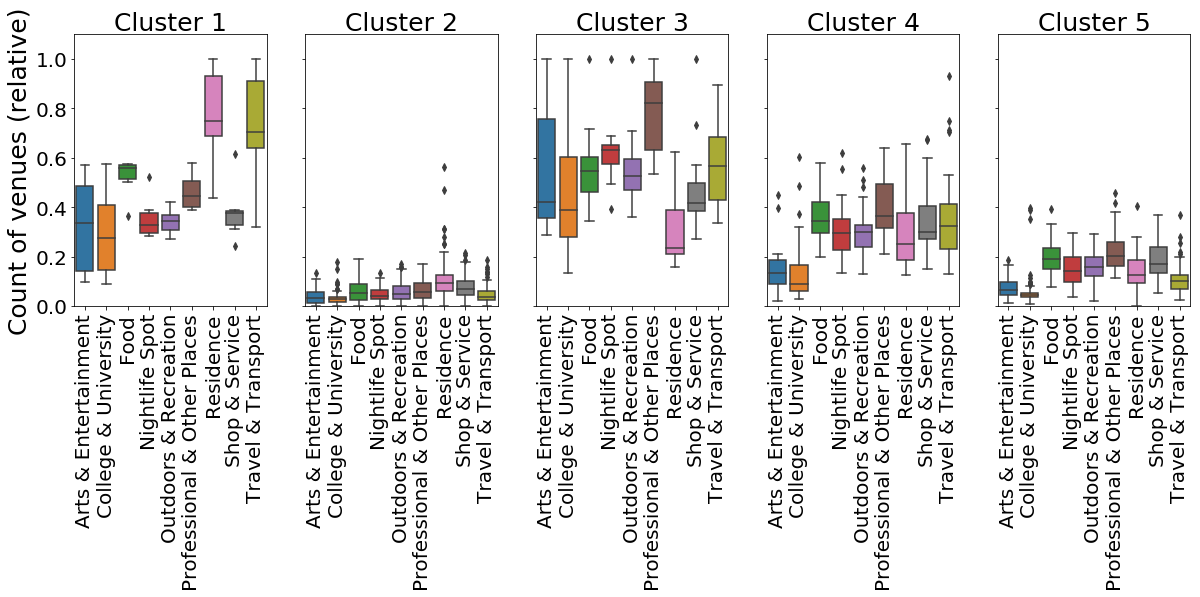

In [171]:
fig, ax= plt.subplots(1, nclusters, figsize=(20,5), sharey=True)

ax[0].set_ylabel('Count of venues (relative)', fontsize=25)

for k in range(0, nclusters):
    #Set same y axis limits
    ax[k].set_ylim(0,1.1)
    ax[k].xaxis.set_label_position('top')
    ax[k].set_xlabel('Cluster ' + str(k+1), fontsize=25)
    ax[k].tick_params(labelsize=20)
    plt.sca(ax[k])
    plt.xticks(rotation=90)
    sns.boxplot(data = wards_venues_scaled[wards_venues_scaled['Cluster'] == k].drop('Cluster',1), ax=ax[k])

plt.show()

In [173]:
wards_clustered.Cluster.value_counts()

1    127
4     77
3     29
2     12
0      6
Name: Cluster, dtype: int64

### Visualize clusters on map

In [174]:
# create map
map_clusters = folium.Map(location=[london_lat, london_lon], zoom_start=11)
palette = cm.get_cmap('Set1') #'rainbow'

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = palette(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, ward, cluster in zip(wards_clustered['centroid_lat'],
                                   wards_clustered['centroid_lon'],
                                   wards_clustered['NAME'],
                                   wards_clustered['Cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=("%i : %s " % (cluster+1, ward)),
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So we have 5 main clusters in our map:

_Red(1) cluster_ - has moderate scores with residential and transport being the most popular. These are highly-developed residential suburbs.  
_Green(2) cluster_ - underdeveloped, has low frequencies of all categories of venues.  
_Orange (3) cluster_ - business or downtown cluster. Highly developed business part of the city, which has very high frequencies for all venue   categories except residential. It is part of the city where people mostly work and entertain, but not live here.  
_Brown(4) cluster_ - highly developed area, has high frequences with less residential places and more professional ones. Developed professional and industrial areas.  
_Grey(5) cluster_ - mid-developed, has moderate frequences of almost all categories with small prevalence of professional places  

In [175]:
geo = json.load(project.get_file('geo_Inner_London_Wards.geojson'))

m = folium.Map(location=[london_lat, london_lon], zoom_start=11)


folium.Choropleth(
    geo_data=geo,
    name='choropleth',
    data=wards_clustered,
    columns=['NAME', 'Cluster'],
    key_on='properties.NAME',
    fill_color='Set1',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cluster Number'
).add_to(m)

for lat, lon, ward, cluster in zip(wards_clustered['centroid_lat'],
                                   wards_clustered['centroid_lon'],
                                   wards_clustered['NAME'],
                                   wards_clustered['Cluster']):
    #folium.Circle([lat, lon], radius=350, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.7).add_to(m)

    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=str(cluster) + ": "+ward,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.3).add_to(m)

folium.LayerControl().add_to(m)

m

#### Population projection

Now let's take a look at population projections for these wards. Will take a look how much will ward will grow in next 20 years.

In [192]:
wards_population = wards_population.pivot(index='Code', columns='Year', values='Population').reset_index()
wards_population.head()

Year       Code   2020   2040
0     E05000026  16246  22634
1     E05000027  11320  11934
2     E05000028  15016  13909
3     E05000029  11353  11315
4     E05000030  11078  11680

In [198]:
wards_population = wards_population.rename_axis(None)
wards_population.head()

Code   2020   2040
0  E05000026  16246  22634
1  E05000027  11320  11934
2  E05000028  15016  13909
3  E05000029  11353  11315
4  E05000030  11078  11680

In [202]:
wards_projection = wards_clustered.merge(wards_population, how='left', left_on="WARD_CODE", right_on="Code")
wards_projection.drop('Code', axis=1, inplace=True)
wards_projection.head()

NAME  WARD_CODE  centroid_lat  centroid_lon  Cluster  \
0  Streatham South  E05000431     51.417380     -0.130382        1   
1    St. Leonard's  E05000428     51.429830     -0.133502        1   
2  Streatham Wells  E05000432     51.429980     -0.121877        1   
3    Knight's Hill  E05000424     51.429287     -0.107899        1   
4         Thornton  E05000433     51.447030     -0.136736        1   

   Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.000000              0.008850  0.024291        0.042254   
1              0.065934              0.000000  0.105263        0.056338   
2              0.065934              0.026549  0.085020        0.049296   
3              0.032967              0.000000  0.052632        0.042254   
4              0.000000              0.026549  0.012146        0.021127   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0                   0.04                     0.028169    0.03125   
1                   0.04                     0.070423    0.06250   
2                   0.03                     0.091549    0.06250   
3                   0.03                     0.056338    0.03125   
4                   0.02                     0.021127    0.15625   

   Shop & Service  Travel & Transport     2020     2040  
0        0.046729             0.01875  14802.0  15963.0  
1        0.154206             0.03125  16463.0  17666.0  
2        0.135514             0.02500  17215.0  18085.0  
3        0.098131             0.02500  15607.0  16537.0  
4        0.032710             0.03750  14893.0  18782.0

In [205]:
wards_projection['population_growth'] = (wards_projection['2040'] - wards_projection['2020'])/wards_projection['2020']
wards_projection.head()

NAME  WARD_CODE  centroid_lat  centroid_lon  Cluster  \
0  Streatham South  E05000431     51.417380     -0.130382        1   
1    St. Leonard's  E05000428     51.429830     -0.133502        1   
2  Streatham Wells  E05000432     51.429980     -0.121877        1   
3    Knight's Hill  E05000424     51.429287     -0.107899        1   
4         Thornton  E05000433     51.447030     -0.136736        1   

   Arts & Entertainment  College & University      Food  Nightlife Spot  \
0              0.000000              0.008850  0.024291        0.042254   
1              0.065934              0.000000  0.105263        0.056338   
2              0.065934              0.026549  0.085020        0.049296   
3              0.032967              0.000000  0.052632        0.042254   
4              0.000000              0.026549  0.012146        0.021127   

   Outdoors & Recreation  Professional & Other Places  Residence  \
0                   0.04                     0.028169    0.03125   
1                   0.04                     0.070423    0.06250   
2                   0.03                     0.091549    0.06250   
3                   0.03                     0.056338    0.03125   
4                   0.02                     0.021127    0.15625   

   Shop & Service  Travel & Transport     2020     2040  population_growth  
0        0.046729             0.01875  14802.0  15963.0           0.078435  
1        0.154206             0.03125  16463.0  17666.0           0.073073  
2        0.135514             0.02500  17215.0  18085.0           0.050537  
3        0.098131             0.02500  15607.0  16537.0           0.059589  
4        0.032710             0.03750  14893.0  18782.0           0.261129

Let's take a look at average and median growth in clusters

In [206]:
wards_projection.groupby('Cluster').mean()['population_growth']

Cluster
0    0.064022
1    0.155709
2    0.124825
3    0.257040
4    0.128877
Name: population_growth, dtype: float64

In [207]:
wards_projection.groupby('Cluster').median()['population_growth']

Cluster
0    0.060728
1    0.048586
2    0.092528
3    0.100742
4    0.083650
Name: population_growth, dtype: float64

In [228]:
# create map
map_clusters_growth = folium.Map(location=[london_lat, london_lon], zoom_start=11)
palette = cm.get_cmap('Set1') #'rainbow'

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i + x + (i*x)**2 for i in range(nclusters)]
colors_array = palette(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, ward, cluster, growth in zip(wards_projection['centroid_lat'],
                               wards_projection['centroid_lon'],
                               wards_projection['NAME'],
                               wards_projection['Cluster'],
                               wards_projection['population_growth'].fillna(0)):

#folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
    folium.Circle([lat, lon],
                  radius=100 + 500 * growth,
                  color='#00000000',
                  fill=True,
                  fill_color='blue',
                  fill_opacity=0.5).add_to(map_clusters_growth)



for lat, lon, ward, cluster in zip(wards_projection['centroid_lat'],
                                   wards_projection['centroid_lon'],
                                   wards_projection['NAME'],
                                   wards_projection['Cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=("%i : %s " % (cluster+1, ward)),
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters_growth)

    
map_clusters_growth

We see that a lot of green(2) cluster areas, which we determined as least developed, shows significant population growth. Also there are couple of brown(4) cluster areas which also stand out.

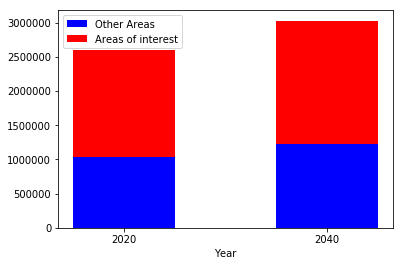

In [255]:
cluster_of_interest = 1

total_2020 = wards_projection['2020'].sum()
total_2040 = wards_projection['2040'].sum()

population_clustered = wards_projection.groupby('Cluster')['2020','2040'].sum()
cluster_2020 = population_clustered.loc[cluster_of_interest][0]
cluster_2040 = population_clustered.loc[cluster_of_interest][1]

bar1 = [(total_2020 - cluster_2020),(total_2040 - cluster_2040)]
bar2 = [cluster_population_2020, cluster_population_2040]

r=[0,2]
names=['2020','2040']
width=1

plt.bar(r, bar1, color='blue', width=width)
plt.bar(r, bar2, bottom=bar1, color='red', width=width)
plt.xticks(r, names)
plt.xlabel("Year")
plt.legend(['Other Areas','Areas of interest']) 
plt.show()

In [256]:
share2020= round((cluster_2020/total_2020)*100,2)
share2040= round((cluster_2040/total_2040)*100,2)
print('{} less developed clusters that host {}% of city\'s population in 2020 will host {}% of total population in 2040'.format(
    wards_projection.groupby('Cluster').size()[0],
    share2020,
    share2040))

6 less developed clusters that host 60.02% of city's population in 2020 will host 59.68% of total population in 2040


As we can see our biggest growing cluster won't change its share of population in future. But everything can happened after our project :)

## Results and Discussion <a name="results"></a>

Our analysis shows that there are distinct areas in Inner London which can be grouped together as similar. There are big number of underdeveloped areas according to presense in them different venue categories which can help identify places for new businesses. Population projection data shows that there will not be a huge growth in population in any of the identified cluster. Nevertheless the most "oportunistic" areas will still share more than a half of city population.  

Identifying currently underdeveloped areas can give big advantage to earlier businesses and service provides in these areas.

## Conclusion <a name="conclusion"></a>

Our main aim was to identify less developed and underdeveloped areas in London. We successfully achieved this goal I believe.

Despite these results it would be interesting to further conduct clustering analysis considering other socio-economic measures like demographics, religion, housing types, employment rates, income per household and many, many other. Fortunately, London Datastore has a huge amount of open data for further analysis and getting deeper insight into future of London areas.